# Computational Graph

In [8]:
import casadi as ca

# Define states
x1 = ca.MX.sym('x1')
x2 = ca.MX.sym('x2')
x = ca.vertcat(x1, x2)  # Vector of states

# Define control
u = ca.MX.sym('u')

# Define the Van der Pol oscillator ODE
ode = ca.vertcat((1 - x2**2) * x1 - x2 + u, x1)

# Create a CasADi function 'f' that maps [x, u] to [ode]
f = ca.Function('f', [x, u], [ode])

# Evaluate the function at a specific point
result = f([0.2, 0.8], 0.1)
print(result)


[-0.628, 0.2]


# Time Integration Methods

In [9]:
from casadi import MX, vertcat, integrator

# Define the time horizon and number of control intervals
T = 10.0
N = 20
dt = T / N

# Define state and input variables
x = MX.sym('x')
u = MX.sym('u')

# Define the differential equation as an expression
ode = (1 - x**2) * x + u  # Example placeholder

# Create a function for the integrator
dae = {'x': x, 'p': u, 'ode': ode}

# Specify options for the integrator
opts = {'tf': dt, 'simplify': True, 'number_of_finite_elements': 4}

# Create the integrator
integr = integrator('integr', 'rk', dae, opts)

# Evaluate the integrator with initial conditions and input
res = integr(x0=0, p=0.5)  # Initial state x0, input u

# Print the final state after the first interval
print("State after first interval:", res['xf'])


State after first interval: 0.32042


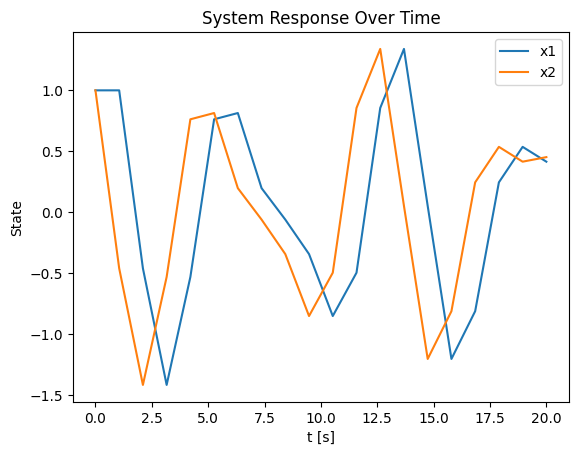

In [14]:
from casadi import MX, Function, DM, linspace, vertcat
import matplotlib.pyplot as plt
from math import cos

# Define the states and input
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u')

# Define the dynamics or transformation function F
x_next = vertcat(x2, -x1 + u)  # Example dynamics
F = Function('F', [vertcat(x1, x2), u], [x_next])  # Notice input grouping for states

# Number of intervals
N = 20

# Initial conditions and input sequence (properly formatted)
x0 = DM([0, 1])  # Initial state
u_sequence = DM([cos(1 * i) for i in range(N)])  # Input sequence

# Prepare function for mapaccum
# Since x_next is 2x1, ensure inputs are properly structured
sim = F.mapaccum(N)

# Call simulation
# Note: x0 and u_sequence need to be properly structured for each step
res = sim(x0, u_sequence)

# Prepare time grid for plotting
tgrid = linspace(0, N, N)  # Changed to have N points to match the output steps

# Plotting
plt.figure()
plt.plot(tgrid, DM(res).full().T)  # Ensure the data transpose for correct dimensions
plt.xlabel('t [s]')
plt.ylabel('State')
plt.legend(['x1', 'x2'])
plt.title('System Response Over Time')
plt.show()


# Symbolic Differentation

Size of Jacobian: (20, 20)


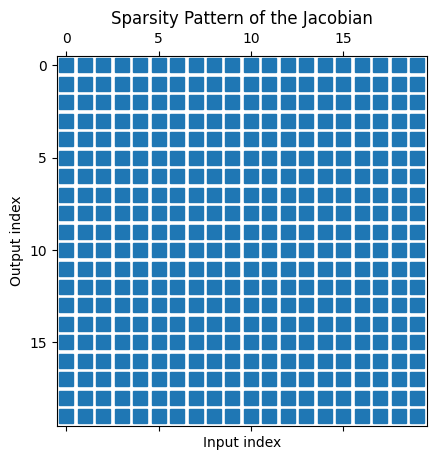

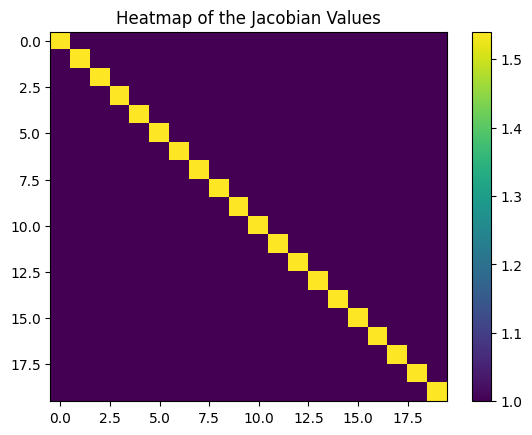

In [19]:
from casadi import MX, Function, jacobian, DM, vertcat
import matplotlib.pyplot as plt

# Define the number of inputs
N = 20

# Define symbolic input
U = MX.sym('U', 1, N)

# Manual cumulative sum calculation
cumulative_sum = MX(0)  # Starting from zero
for i in range(N):
    cumulative_sum += U[:, i]

# Define a system function using U
X1 = MX.sin(U) + cumulative_sum  # Adding cumulative sum to sin(U)

# Calculate the Jacobian of the system output with respect to the input
J = jacobian(X1, U)

# Create a CasADi function for the Jacobian
Jf = Function('Jf', [U], [J])

# Evaluate the Jacobian with a specific example
input_example = DM.ones(1, N)  # Uniform input for simplicity
result_J = Jf(input_example)

# Print the size of the Jacobian
print("Size of Jacobian:", J.size())

# Visualize the sparsity pattern of the Jacobian
plt.spy(result_J.sparse())
plt.title("Sparsity Pattern of the Jacobian")
plt.xlabel("Input index")
plt.ylabel("Output index")
plt.show()

# Optionally, visualize the full matrix using imshow
plt.figure()
plt.imshow(result_J.full(), aspect='auto', interpolation='none', cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Jacobian Values")
plt.show()




# Optimal control problem using multiple-shootinh

In [20]:
from casadi import Opti, sumsqr, vertcat

# Create a new optimization problem
opti = Opti()

# Define variables
N = 20  # Define the horizon length
x = opti.variable(2, N+1)  # State variables over N+1 time steps
u = opti.variable(1, N)    # Control inputs over N time steps
p = opti.parameter(2, 1)   # Parameters (not optimized over)

# Objective function: minimize the sum of squares of states and controls
opti.minimize(sumsqr(x) + sumsqr(u))

# System dynamics placeholder function (you will need to define this)
def system_dynamics(xk, uk):
    # This should return the next state
    # For now, let's just return a simple linear dynamics as a placeholder
    return xk + uk

# Constraints
for k in range(N):
    # System dynamics constraint
    opti.subject_to(x[:, k+1] == system_dynamics(x[:, k], u[:, k]))

# Input constraints
opti.subject_to(opti.bounded(-1, u, 1))

# Initial condition constraint
opti.subject_to(x[:, 0] == p)

# Setup the solver (need to specify a solver, e.g., 'ipopt')
opti.solver('ipopt')

# If you have initial guesses or parameters to set, do it here
opti.set_value(p, [0.5, 0.5])

# Solve the problem
sol = opti.solve()

# Extract solutions
x_solution = sol.value(x)
u_solution = sol.value(u)

print("Optimized State Trajectory:", x_solution)
print("Optimized Control Inputs:", u_solution)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      122
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:       62

Total number of variables............................:       62
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       42
Total number of inequality c

In [21]:
from casadi import Opti

# Create an optimization problem
opti = Opti()

# Define your variables, parameters, objective, and constraints here
# For example:
x = opti.variable()
p = opti.parameter()
opti.minimize(x**2 + p)
opti.subject_to(x + p >= 1)

# Choose a concrete solver and set options
# In MATLAB you have 'sqpmethod' and 'qpsol' as 'qrqp'
# Let's assume you want to use 'ipopt' or another suitable solver available in CasADi
opti.solver('ipopt', {"expand": True})  # The expand option is generally beneficial for speed
#opti.solver('sqpmethod', {'qpsol': 'qrqp', 'qpsol_options': {'print_level': 0}})


# Set a concrete value for the parameter p
opti.set_value(p, 1)

# Solve the optimization problem
sol = opti.solve()

# Retrieve the solution
x_solution = sol.value(x)
print("Solution x:", x_solution)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 0.00e+00 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

# Geature Highlight 1 from Opti (NLP modeling) to CasADi Functions

In [31]:
from casadi import Opti

# Create an Opti instance
opti = Opti()

# Define variables and parameters
x = opti.variable()
p = opti.parameter()

# Define the objective
opti.minimize(x**2 + p)

# Add a constraint
opti.subject_to(x + p == 1)

# Specify the solver
opti.solver('ipopt')

# Correctly convert the Opti problem to a CasADi function
# The correct syntax does not include a mapping dictionary for outputs directly
M = opti.to_function('M', [p], [x])

# Set the value of p and evaluate M
opti.set_value(p, 0.5)
x_opt = M()
print("Optimized x:", x_opt)



This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

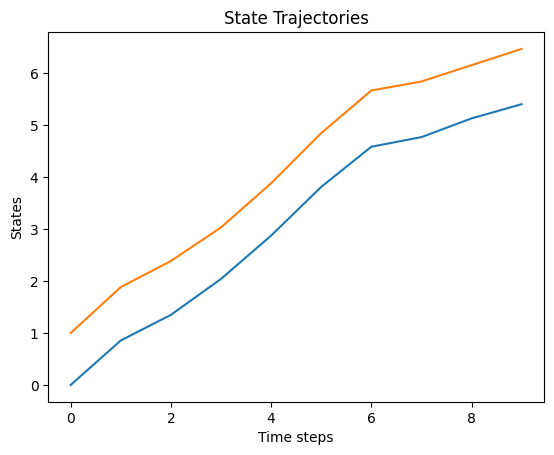

In [32]:
import casadi as ca
import numpy as np

# Define the optimization function M and system dynamics function F
# Assuming these are defined elsewhere in your code:
def M(x):
    # Placeholder for the optimization function
    # Returns an optimal control action based on state x
    return np.random.rand()  # Replace with actual optimization logic

def F(x, u):
    # Placeholder for the system dynamics function
    # Computes the next state based on current state x and control action u
    return x + u  # Replace with actual system dynamics

# MPC Loop Setup
N = 10  # Number of MPC iterations, replace with your actual horizon
X_log = []
U_log = []

# Initial state
x = np.array([0, 1])

# MPC Loop
for i in range(N):
    u = M(x)  # Solve the optimization problem to get control action
    U_log.append(u)
    X_log.append(x)
    
    # Simulate system with added noise
    x = F(x, u) + np.random.randn(*x.shape) * 0.02

# Convert logs to numpy arrays for easier handling
X_log = np.array(X_log)
U_log = np.array(U_log)

# Example plot (if needed)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X_log)
plt.title('State Trajectories')
plt.xlabel('Time steps')
plt.ylabel('States')
plt.show()


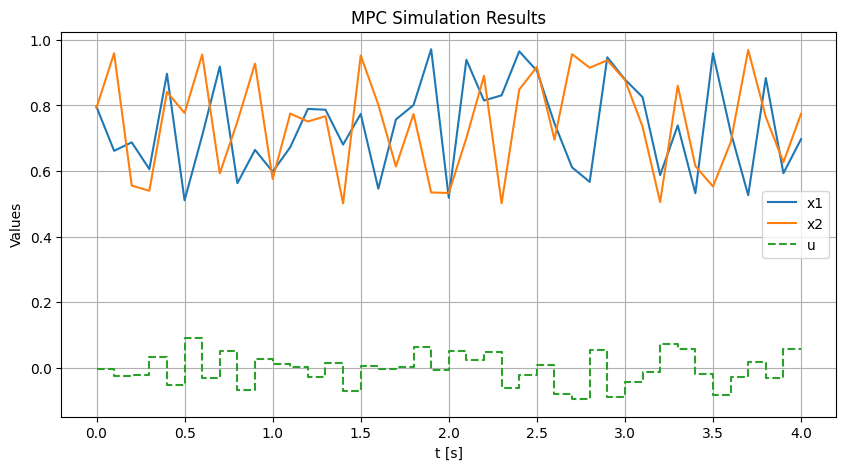

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data generation (replace this with your actual data)
N = 40  # Number of MPC intervals
dt = 0.1  # Time step duration
X_log = np.random.rand(2, N+1) * 0.5 + 0.5  # Simulated state logs for 2 states
U_log = np.random.rand(N) * 0.2 - 0.1  # Simulated control input log

# Creating time grids for states and controls
t_grid = np.linspace(0, N*dt, N+1)  # Time grid for state logging
u_time = np.linspace(0, N*dt, N+1)  # Time grid for control actions

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t_grid, X_log[0, :], label='x1')  # State x1
plt.plot(t_grid, X_log[1, :], label='x2')  # State x2
plt.step(u_time, np.append(U_log, np.nan), where='post', linestyle='--', label='u')  # Control input u
plt.xlabel('t [s]')
plt.ylabel('Values')
plt.title('MPC Simulation Results')
plt.legend()
plt.grid(True)
plt.show()


# Feature highlight 2 loading and saving function objects 

In [37]:
from casadi import DM, SX, Function

# Define a simple function
x = SX.sym('x')
y = SX.sym('y')
f = x**2 + y**2
F = Function('F', [x, y], [f])

# Save the function to a file
F.save('F.casadi')

# Load the function from the file
F_loaded = Function.load('F.casadi')

# Optionally set precision for printing DM objects
DM.set_precision(15)

# Test the functions
x_val = 1.5
y_val = 2.5
print("Original function output:", F(x_val, y_val))
print("Loaded function output:", F_loaded(x_val, y_val))


Original function output: 8.5
Loaded function output: 8.5


# Feature highlight 3 Code-generation with solver embedded

In [39]:
from casadi import SX, Function

# Define the function
x = SX.sym('x')
y = x**2 + 1
f = Function('f', [x], [y])


In [40]:
# Generate C code for the function
f.generate('codegen_demo', {'mex': True})


'codegen_demo.c'



After generating the C code, switch to MATLAB to compile it:
mex codegen_demo.c

Use the Compiled MEX File in MATLAB

result = codegen_demo(3.0);
disp(['Result: ', num2str(result)]);

